# COMP4318/5318 Assignment 2: Image Classification

### Group number: A2 group 165, SID1: 540876279, SID2: 540871296, SID3: 540613397

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [ ]:
#init
import numpy as np
import pandas as pd
import time, os, warnings, pathlib, json, random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

#tunning
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.decomposition import PCA
import tensorflow as tf
import keras_tuner as kt

#model
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#evaluate
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
    
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

def plot_each_class(X, y, n_per_class=10):
    num_classes = len(np.unique(y))

    for cls in range(num_classes):
        idxs = np.where(y == cls)[0][:n_per_class]
        print(f"Class {cls}: showing {len(idxs)} samples")
        # n_rows=4, n_cols=10
        plot_examples(X[idxs], n_rows=1, n_cols=n_per_class)


def plot_history(history,y_lb=0,y_ub=1):
    # Convert the history dictionary to a Pandas dataframe and extract the accuracies
    accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

    # Plot the accuracies
    accuracies.plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(y_lb, y_ub)
    plt.xlabel('Epoch')
    plt.show()

# PrecisionRecallCallback
class PrecisionRecallCallback(keras.callbacks.Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.precisions = []
        self.recalls = []
        self.train_precisions = []
        self.train_recalls = []

    def on_epoch_end(self, epoch, logs=None):
        # Validation set
        y_pred_val_probs = self.model.predict(self.X_val, verbose=0)
        y_pred_val = np.argmax(y_pred_val_probs, axis=1)
        self.precisions.append(precision_score(self.y_val, y_pred_val, average='macro'))
        self.recalls.append(recall_score(self.y_val, y_pred_val, average='macro'))

        # Training set
        y_pred_train_probs = self.model.predict(self.X_train, verbose=0)
        y_pred_train = np.argmax(y_pred_train_probs, axis=1)
        self.train_precisions.append(precision_score(self.y_train, y_pred_train, average='macro'))
        self.train_recalls.append(recall_score(self.y_train, y_pred_train, average='macro'))

## 1. Data loading, exploration, and preprocessing


### 1.1 load data

Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

In [32]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train_full = np.load('Assignment2Data/X_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_train_full = np.load('Assignment2Data/y_train.npy')
y_test = np.load('Assignment2Data/y_test.npy')


In [33]:
print(X_train_full.shape,X_test.shape,y_train_full.shape,y_test.shape) 

(32000, 28, 28, 3) (8000, 28, 28, 3) (32000,) (8000,)


### 1.2 data visualization: Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

In [34]:
print("type of class: ", np.unique(y_train_full))
print("number of class/size of output layer: ", len(np.unique(y_train_full)))

type of class:  [0 1 2 3 4 5 6 7 8]
number of class/size of output layer:  9


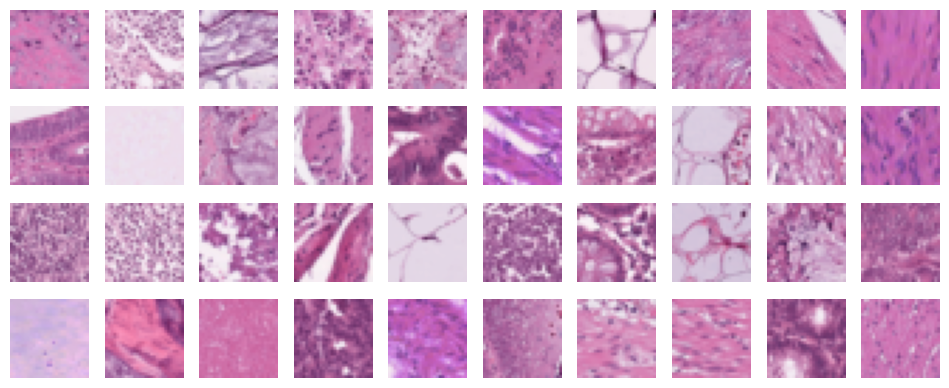

In [35]:
plot_examples(X_train_full)

by the class EDA we can image: 基于H&E染色的经验推断组织切片样本 
where 
class0: 脂肪组织（adipose tissue）</br>
class1: 背景切片、空白或非组织片段 </br>
class2: 肿瘤组织、癌细胞聚集区 </br>
class3: 淋巴组织（lymphoid tissue）或炎症细胞 </br>
class4: 肌肉组织（skeletal or smooth muscle）（平滑或骨骼肌）</br>
class5: 腺体组织（glandular epithelium）腺体上皮或良性腺样结构 </br>
class6: 高度异型或坏死性组织/肿瘤区域 </br>
class7: 间质组织（结缔组织、纤维组织）</br>
class8: 腺癌/上皮组织肿瘤区域</br>

Class 0: showing 10 samples


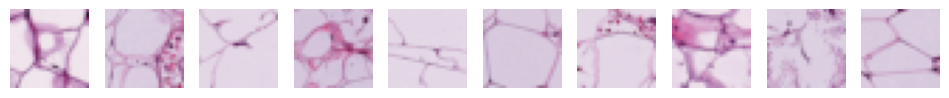

Class 1: showing 10 samples


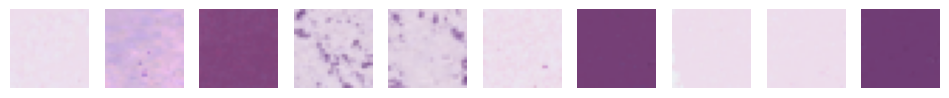

Class 2: showing 10 samples


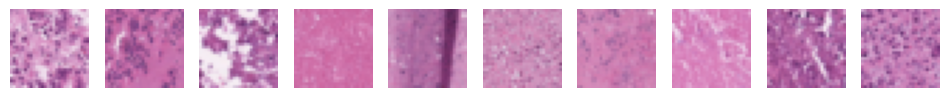

Class 3: showing 10 samples


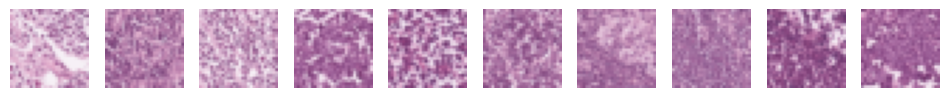

Class 4: showing 10 samples


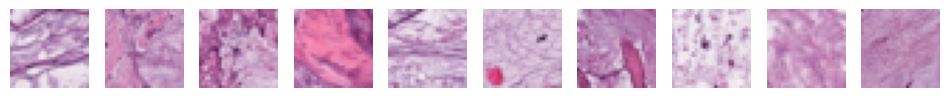

Class 5: showing 10 samples


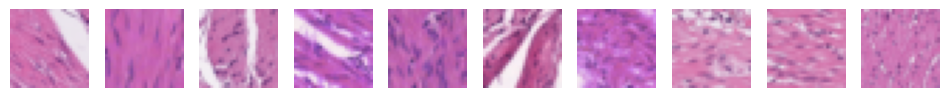

Class 6: showing 10 samples


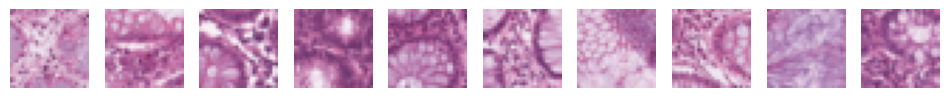

Class 7: showing 10 samples


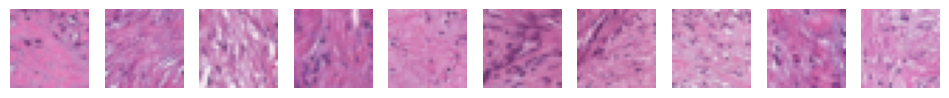

Class 8: showing 10 samples


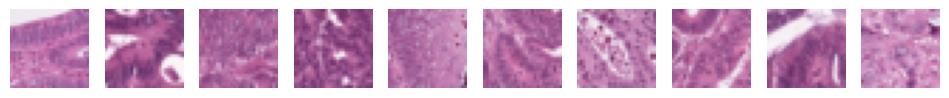

In [36]:
plot_each_class(X_train_full, y_train_full, n_per_class=10)

### 1.3 descriptive analysis

In [37]:
print("type of class: ", np.unique(y_train_full))
print("number of class/size of output layer: ", len(np.unique(y_train_full)))

type of class:  [0 1 2 3 4 5 6 7 8]
number of class/size of output layer:  9


data distribution

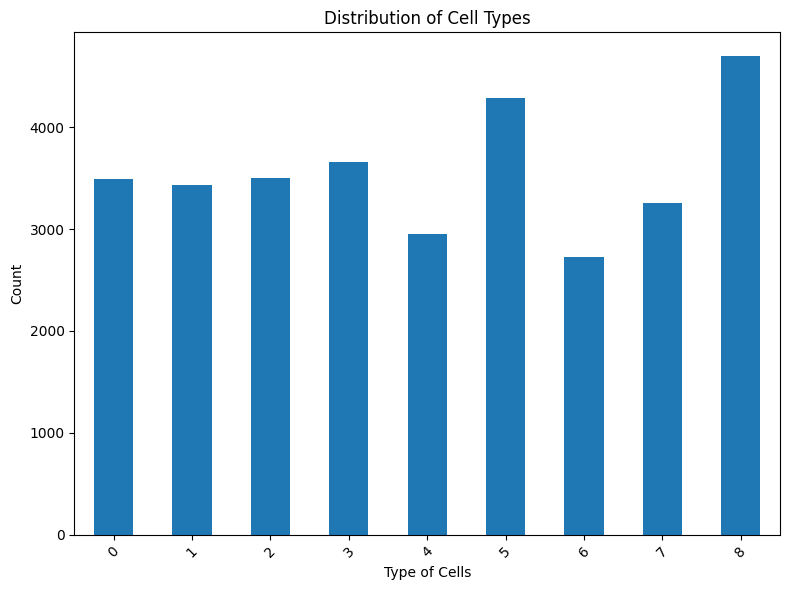

In [38]:
plt.figure(figsize=(8, 6))
pd.Series(y_train_full).value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Cell Types")
plt.xlabel("Type of Cells")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 1.4 normalized data and split train vaild data

In [39]:
# Scale the data to the range 0-1
X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, shuffle=True, stratify=y_train_full, random_state=42)
print(X_train.shape,X_valid.shape,X_test.shape) 

(24000, 28, 28, 3) (8000, 28, 28, 3) (8000, 28, 28, 3)


### 1.5 feature extraction & PCA

In [41]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

pca=PCA(n_components=0.95) #2352降到330维
X_train_pca = pca.fit_transform(X_train_flat)
X_valid_pca = pca.transform(X_valid_flat)
X_test_pca = pca.transform(X_test_flat)
len(pca.components_)

330

by elbo method, around 50 estimator is good enough information for major information
we use 330 and 50 respectively to test how model works

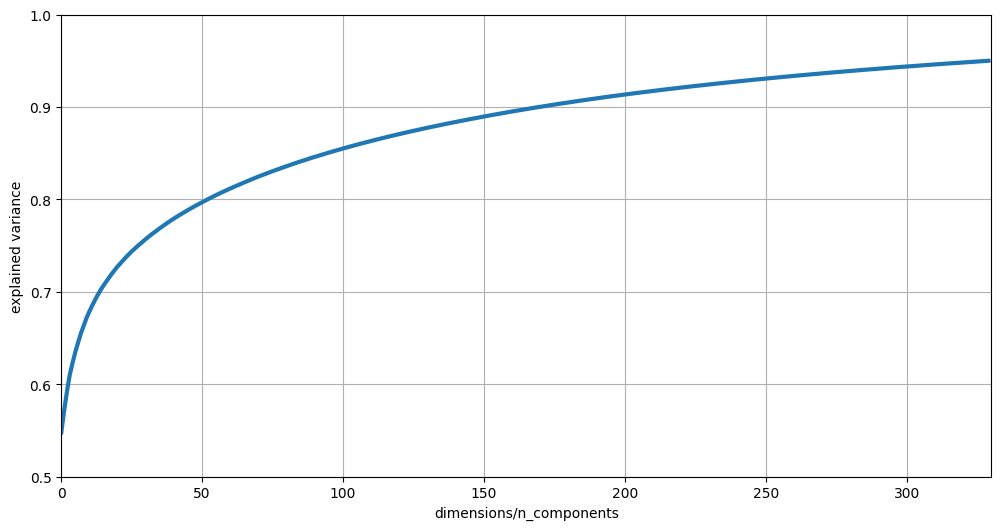

In [42]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance vs number of dimensions
plt.figure(figsize=(12, 6))
plt.plot(cumsum, linewidth=3)
plt.axis([0,len(pca.components_), 0.5, 1])
plt.xlabel("dimensions/n_components")
plt.ylabel("explained variance")
plt.grid(True)
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [ ]:
#data from PCA
X_tr = X_train_pca
X_val = X_valid_pca
y_tr = y_train
y_val = y_valid

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200,       
    max_depth=None,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

# train and validation
start = time.time()
rf.fit(X_tr, y_tr)
val_pred = rf.predict(X_val)

print("Baseline Val Accuracy:", accuracy_score(y_val, val_pred))
print("Baseline Val F1-score :", f1_score(y_val, val_pred, average="weighted"))
print("Fit time %.1fs" % (time.time()-start))


Baseline Val Accuracy: 0.650125
Baseline Val F1 : 0.628471699236885
Fit time 14.7s


### Fully connected neural network

In [ ]:
# Define our MLP layer by layer
model = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_pca.shape[1],)),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(np.unique((y_train))), activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │        99,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,309 (509.02 KB)

 Trainable params: 130,309 (509.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# === parameter setting ===
batch_size = 128
epochs = 30

#opt = keras.optimizers.Adam()
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train_pca, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_pca, y_valid))
loss, accuracy = model.evaluate(X_test_pca, y_test)

print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1385 - loss: 2.3760 - val_accuracy: 0.2984 - val_loss: 1.9844
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2076 - loss: 2.1754 - val_accuracy: 0.3170 - val_loss: 1.9244
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2361 - loss: 2.1063 - val_accuracy: 0.3321 - val_loss: 1.8843
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2542 - loss: 2.0621 - val_accuracy: 0.3431 - val_loss: 1.8496
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2722 - loss: 2.0223 - val_accuracy: 0.3553 - val_loss: 1.8194
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2914 - loss: 1.9866 - val_accuracy: 0.3660 - val_loss: 1.7910
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2870 - loss: 1.9593 - val_accuracy: 0.3764 - val_loss: 1.7663
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3008 - loss: 1.9403 - val_accuracy: 0.

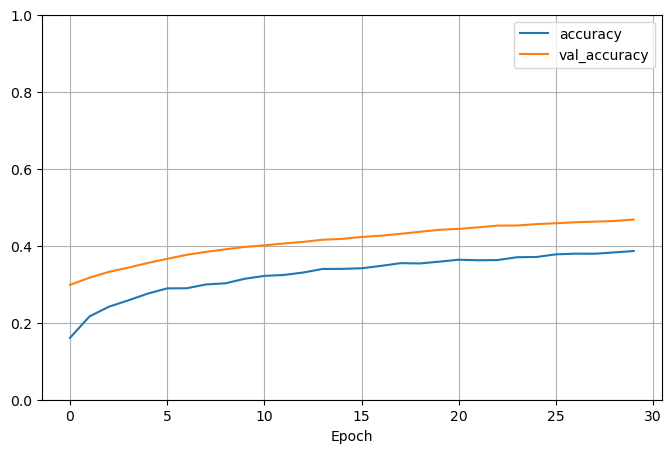

In [ ]:
plot_history(history)

### Convolutional neural network

In [ ]:
# ===== global Variable start =====

# === parameter setting ===
batch_size = 128
epochs = 40
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

# === L2 regular ===
l2_reg = regularizers.l2(1e-4)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
# ===== global Variable end =====

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4034 - loss: 1.6368 - val_accuracy: 0.2237 - val_loss: 2.0675 - learning_rate: 0.0010
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5900 - loss: 1.1191 - val_accuracy: 0.1978 - val_loss: 1.9191 - learning_rate: 0.0010
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6452 - loss: 0.9976 - val_accuracy: 0.5160 - val_loss: 1.3594 - learning_rate: 0.0010
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6870 - loss: 0.8977 - val_accuracy: 0.5196 - val_loss: 1.4020 - learning_rate: 0.0010
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7068 - loss: 0.8318 - val_accuracy: 0.5670 - val_loss: 1.1662 - learning_rate: 0.0010
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7248 - loss: 0.7901 - val_accuracy: 0.6033 - val_loss: 1.4359 - learning_rate: 0.0010
Epoch 7/30
182/188 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7416 - loss: 0.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,077 (258.12 KB)

 Trainable params: 21,961 (85.79 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 43,924 (171.58 KB)

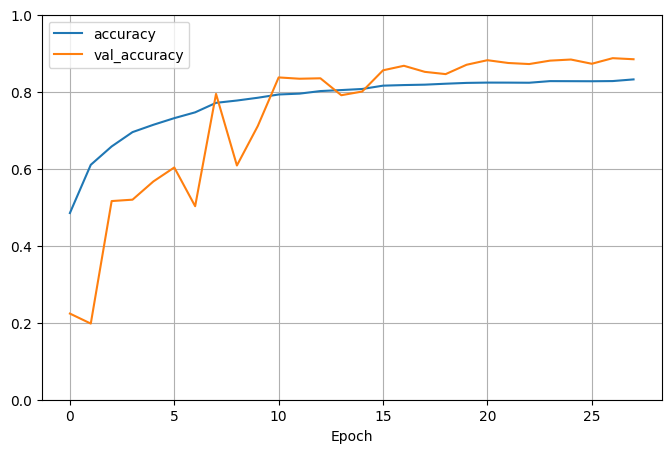

In [ ]:
plot_history(history)

## 3. Hyperparameter tuning

### Algorithm of choice from first six weeks of course

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None, 20, 40],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_tr, y_tr)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)


best_rf = grid_search.best_estimator_
val_pred = best_rf.predict(X_val)
print("Val accuracy:", accuracy_score(y_val, val_pred))
print("Val F1-score:", f1_score(y_val, val_pred, average="weighted"))


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=None, max_features=sqrt, n_estimators=150; total time=  54.2s
[CV] END max_depth=None, max_features=log2, n_estimators=100; total time=  18.1s
[CV] END max_depth=None, max_features=log2, n_estimators=150; total time=  28.0s
[CV] END max_depth=None, max_features=log2, n_estimators=200; total time=  39.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=150; total time=  58.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=250; total time= 1.6min
[CV] END ..max_depth=40, max_features=sqrt, n_estimators=150; total time=  59.9s
[CV] END ..max_depth=40, max_features=log2, n_estimators=100; total time=  20.3s
[CV] END ..max_depth=40, max_features=log2, n_estimators=100; total time=  20.7s
[CV] END ..max_depth=40, max_features=log2, n_estimators=150; total time=  31.2s
[CV] END ..max_depth=40, max_features=log2, n_estimators=250; total time=  31.6s
[CV] END max_depth=None, max_features=sqrt, n_es

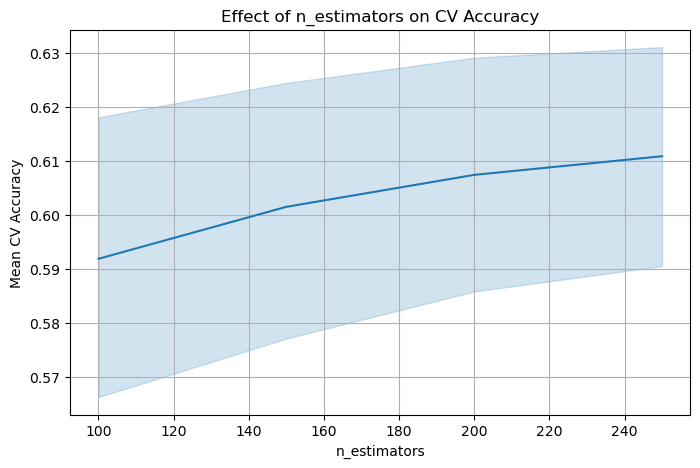

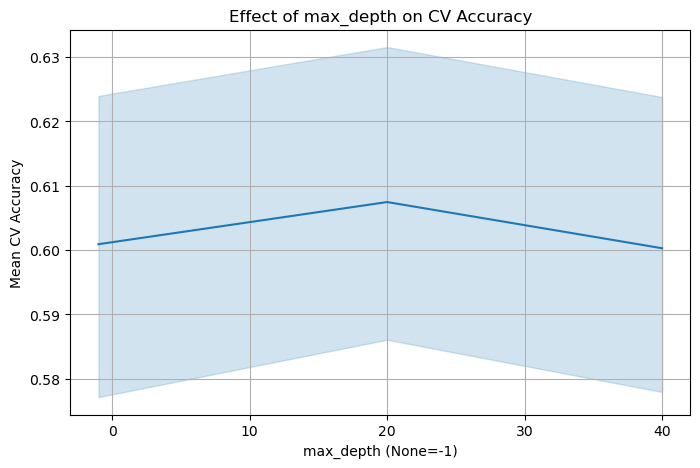

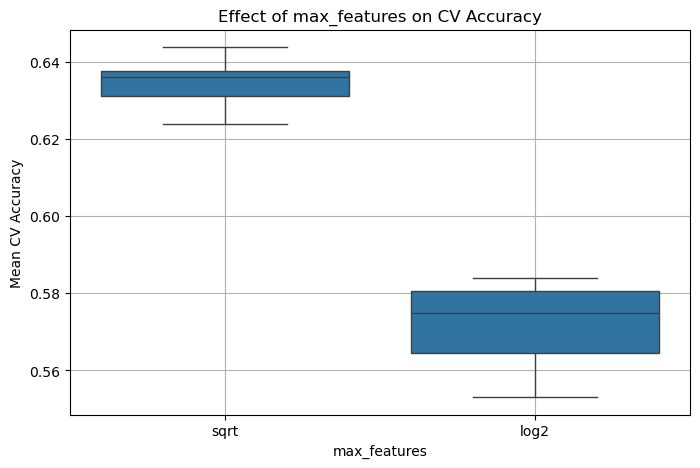

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

# n_estimators vs CV accuracy
plt.figure(figsize=(8, 5))
sns.lineplot(
    x=results["param_n_estimators"], 
    y=results["mean_test_score"]
)
plt.xlabel("n_estimators")
plt.ylabel("Mean CV Accuracy")
plt.title("Effect of n_estimators on CV Accuracy")
plt.grid(True)
plt.show()


# max_depth vs CV accuracy
results["param_max_depth"] = results["param_max_depth"].fillna(-1)  
plt.figure(figsize=(8, 5))
sns.lineplot(
    x=results["param_max_depth"], 
    y=results["mean_test_score"]
)
plt.xlabel("max_depth (None=-1)")
plt.ylabel("Mean CV Accuracy")
plt.title("Effect of max_depth on CV Accuracy")
plt.grid(True)
plt.show()


# max_features vs CV accuracy
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=results["param_max_features"], 
    y=results["mean_test_score"]
)
plt.xlabel("max_features")
plt.ylabel("Mean CV Accuracy")
plt.title("Effect of max_features on CV Accuracy")
plt.grid(True)
plt.show()

### Fully connected neural network

In [ ]:
# Define our MLP layer by layer
model = keras.models.Sequential([
    keras.layers.Input(shape=(X_train_pca.shape[1],)),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(np.unique((y_train))), activation="softmax")
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │        99,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           909 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,309 (509.02 KB)

 Trainable params: 130,309 (509.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Parameter settings
batch_size = 128
epochs = 30

#opt = keras.optimizers.Adam()
opt = keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(X_train_pca, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_valid_pca, y_valid))
loss, accuracy = model.evaluate(X_test_pca, y_test)

print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1488 - loss: 2.3117 - val_accuracy: 0.2730 - val_loss: 1.9934
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2078 - loss: 2.1788 - val_accuracy: 0.2946 - val_loss: 1.9364
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2310 - loss: 2.1170 - val_accuracy: 0.3121 - val_loss: 1.8944
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2485 - loss: 2.0668 - val_accuracy: 0.3291 - val_loss: 1.8585
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2632 - loss: 2.0385 - val_accuracy: 0.3415 - val_loss: 1.8269
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2761 - loss: 2.0043 - val_accuracy: 0.3543 - val_loss: 1.7986
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2842 - loss: 1.9833 - val_accuracy: 0.3654 - val_loss: 1.7723
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2933 - loss: 1.9507 - val_accuracy: 0.

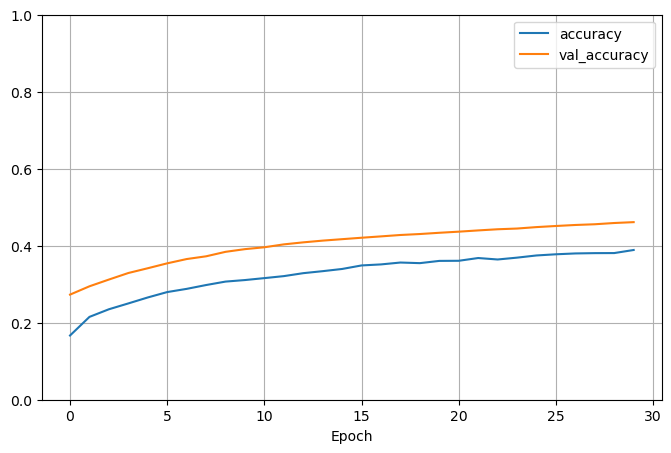

In [ ]:
plot_history(history)

### Convolutional neural network

In [ ]:
# ===== global Variable start =====
# === parameter setting ===
batch_size = 128
epochs = 40
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

# === L2 regular ===
l2_reg = regularizers.l2(1e-4)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
# ===== global Variable end =====

#### all hyper parameter
it is clear to see the combination is too much, and there are two conv layers

In [ ]:
filterNum=[16,32,64]
kenSz=[3,5]
neuronNum=[100, 200, 300]
activateFns=["relu", "tanh"]
dropRate=[0.3, 0.4, 0.5]
lr=[0.01, 0.001]

#### tunning filter number & kernel size first

In [ ]:
#hyper parameter
filterNum=[16,32,64]
kenSz=[3,5]
# lr=[0.01, 0.001, 0.0001]
# dropRate=[0.3, 0.4, 0.5]
# neuronNum==[32, 64, 100, 200]
# activateFns=["relu", "tanh"]

def build_model(hp):
    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Input(shape=input_shape))

    # conv layer two
    for i in range(1, 3):
        model.add(
            layers.Conv2D(filters = hp.Choice(f"filter_{i}", values=filterNum),
                        kernel_size = hp.Choice(f"kernalSz_{i}", values=kenSz),
                        # activation = hp.Choice(f"activateFns_{i}", values=activateFns),
                        padding = 'same',
                        kernel_regularizer = l2_reg,
                        input_shape=input_shape
            )
        )
        model.add(layers.BatchNormalization())

    #pool layer
    model.add(
        layers.MaxPooling2D(pool_size=(2, 2)) #图像本来就小，pool不用那么激进 pool_size=(3,3)
    )
    model.add(
        layers.Dropout(
            rate=0.4
            #rate=hp.Choice("rate",values=dropRate)
            )
    )
    model.add(
        layers.GlobalAveragePooling2D()
    )

    #fcn==fully connected network
    model.add(
        layers.Dense(
                # units=hp.Choice(f"units", values=neuronNum),
                units = 32,
                # activation=hp.Choice("activation", values=activateFns),
                kernel_regularizer=l2_reg
        )
    )
    model.add(
        keras.layers.Dropout(
            rate=0.4
            # rate=hp.Choice("rate",values=dropRate)
        )
    )

    #output layer
    model.add(
        layers.Dense(num_classes, activation='softmax') #output layer
    )

    # === compile model ===
    # learning_rate = hp.Choice('learning_rate', values=lr)
    learning_rate = 1e-3
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=None, # search all possibility
    executions_per_trial=1
    # overwrite=False,
    # directory="keras_tuning_results",
    # project_name="cnn_assgn2"
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
filter_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernalSz_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
filter_2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
kernalSz_2 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid),batch_size=batch_size,callbacks=callbacks)

Trial 36 Complete [00h 00m 34s]
val_accuracy: 0.6121249794960022

Best val_accuracy So Far: 0.7592499852180481
Total elapsed time: 00h 24m 57s


In [ ]:
tuner.results_summary(10) #display best 10 trials

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0031 summary
Hyperparameters:
filter_1: 16
kernalSz_1: 3
filter_2: 64
kernalSz_2: 5
Score: 0.7592499852180481

Trial 0025 summary
Hyperparameters:
filter_1: 64
kernalSz_1: 3
filter_2: 64
kernalSz_2: 5
Score: 0.753000020980835

Trial 0018 summary
Hyperparameters:
filter_1: 64
kernalSz_1: 3
filter_2: 32
kernalSz_2: 5
Score: 0.7278749942779541

Trial 0020 summary
Hyperparameters:
filter_1: 32
kernalSz_1: 3
filter_2: 32
kernalSz_2: 3
Score: 0.7271249890327454

Trial 0029 summary
Hyperparameters:
filter_1: 16
kernalSz_1: 5
filter_2: 64
kernalSz_2: 5
Score: 0.7170000076293945

Trial 0004 summary
Hyperparameters:
filter_1: 16
kernalSz_1: 3
filter_2: 32
kernalSz_2: 5
Score: 0.7158750295639038

Trial 0007 summary
Hyperparameters:
filter_1: 16
kernalSz_1: 3
filter_2: 16
kernalSz_2: 5
Score: 0.7146250009536743

Trial 0010 summary
Hyperparameters:
filter_1: 32
kernalSz_1: 3
f

In [ ]:
# 从 Keras Tuner 提取 trials
records = []
for trial in tuner.oracle.get_trials().values():
    hp = trial.hyperparameters.values
    acc = trial.metrics.get_best_value('val_accuracy')
    records.append({
        'filter_1': hp.get('filter_1'),
        'ken_1': hp.get('ken_1'),
        'filter_2': hp.get('filter_2'),
        'ken_2': hp.get('ken_2'),
        'val_accuracy': acc
    })

df = pd.DataFrame(records)

# 可视化：对于每一组 ken_1 × ken_2，画 filter_1 × filter_2 的热力图
unique_k1 = sorted(df['ken_1'].unique())
unique_k2 = sorted(df['ken_2'].unique())

for k1 in unique_k1:
    for k2 in unique_k2:
        subset = df[(df['ken_1'] == k1) & (df['ken_2'] == k2)]
        pivot = subset.pivot(index='filter_2', columns='filter_1', values='val_accuracy')
        
        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
        plt.title(f"val_accuracy (ken_1={k1}, ken_2={k2})")
        plt.xlabel("filter_1")
        plt.ylabel("filter_2")
        plt.tight_layout()
        plt.show()

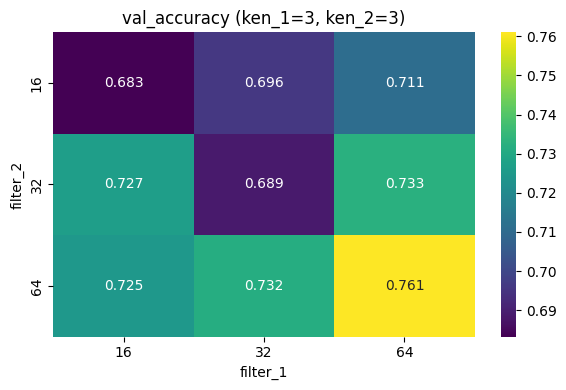

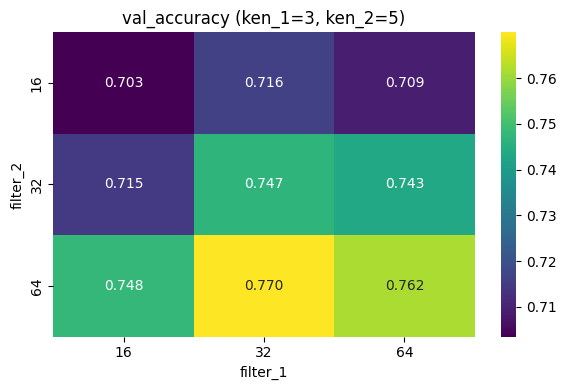

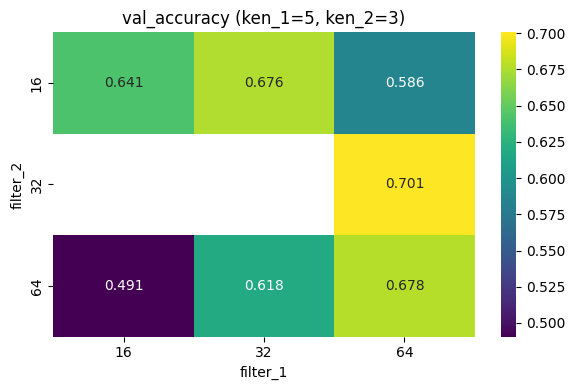

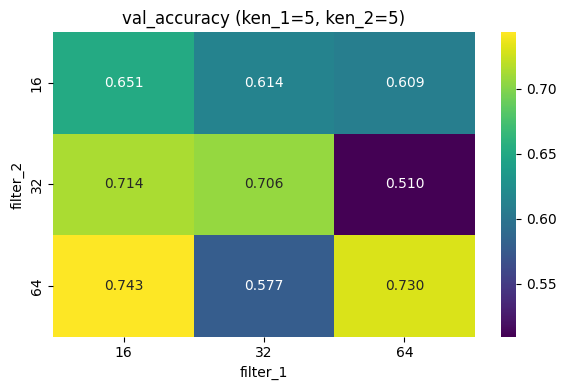

In [ ]:
# 从 Keras Tuner 提取 trials
records = []
for trial in tuner.oracle.trials.values():
    hp = trial.hyperparameters.values
    acc = trial.metrics.get_best_value('val_accuracy')
    records.append({
        'filter_1': hp.get('filter_1'),
        'ken_1': hp.get('kernalSz_1'),
        'filter_2': hp.get('filter_2'),
        'ken_2': hp.get('kernalSz_2'),
        'val_accuracy': acc
    })

df = pd.DataFrame(records)

# 可视化：对于每一组 ken_1 × ken_2，画 filter_1 × filter_2 的热力图
unique_k1 = sorted(df['ken_1'].unique())
unique_k2 = sorted(df['ken_2'].unique())

for k1 in unique_k1:
    for k2 in unique_k2:
        subset = df[(df['ken_1'] == k1) & (df['ken_2'] == k2)]
        pivot = subset.pivot(index='filter_2', columns='filter_1', values='val_accuracy')

        plt.figure(figsize=(6, 4))
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
        plt.title(f"val_accuracy (ken_1={k1}, ken_2={k2})")
        plt.xlabel("filter_1")
        plt.ylabel("filter_2")
        plt.tight_layout()
        plt.show()

#### compare top-2 hyperparam model

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.3781 - loss: 1.6885 - val_accuracy: 0.2431 - val_loss: 2.0838 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5987 - loss: 1.1203 - val_accuracy: 0.2661 - val_loss: 1.8056 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6728 - loss: 0.9297 - val_accuracy: 0.5414 - val_loss: 1.2075 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6969 - loss: 0.8599 - val_accuracy: 0.4803 - val_loss: 1.6923 - learning_rate: 0.0010
Epoch 5/40
184/188 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7283 - loss: 0.7816
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7282 - loss: 0.7817 - val_accuracy: 0.5689 - val_loss: 1.7647 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7422 - loss: 0.7294 

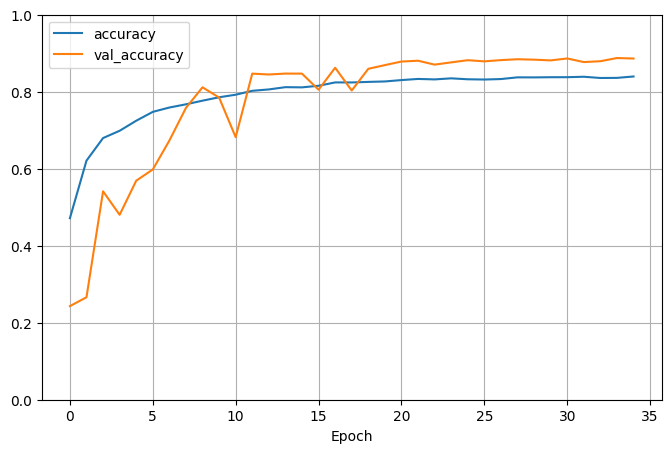

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.3965 - loss: 1.6856 - val_accuracy: 0.1094 - val_loss: 2.1788 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6208 - loss: 1.0778 - val_accuracy: 0.2866 - val_loss: 1.9412 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6712 - loss: 0.9369 - val_accuracy: 0.3820 - val_loss: 1.4819 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7099 - loss: 0.8397 - val_accuracy: 0.4735 - val_loss: 1.3106 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7313 - loss: 0.7904 - val_accuracy: 0.4837 - val_loss: 1.6619 - learning_rate: 0.0010
Epoch 6/40
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7505 - loss: 0.7343
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7506 - loss: 0.

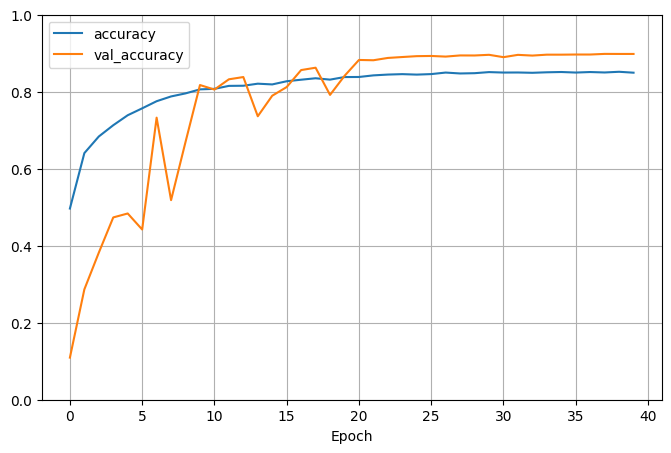

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === build model ===
model = keras.Sequential([
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=40,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

#### tunning learning rate & drop rate
for previous two model, although second has higher accuarcy, first one is better in lower dimension and better generalization<br>
we use filter_1 16 ken_1 3 filter_2 64 ken_2 5 from first greedy search

In [ ]:
#hyper parameter
lr=[0.01, 0.001, 0.0001]
dropRate=[0.3, 0.4, 0.5]
# neuronNum=[100, 200, 300]
# activateFns=["relu", "tanh"]

def build_model(hp):
    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Input(shape=input_shape))

    # === L2 regular ===
    l2_reg = regularizers.l2(1e-4)

    # conv layer two
    model.add(
            layers.Conv2D(filters = 16,
                        kernel_size = 3,
                        # activation = hp.Choice(f"activateFns_1", values=activateFns),
                        padding = 'same',
                        kernel_regularizer = l2_reg,
                        input_shape=input_shape
            )
        )
    model.add(layers.BatchNormalization())

    model.add(
            layers.Conv2D(filters = 64,
                        kernel_size = 5,
                        # activation = hp.Choice(f"activateFns_2", values=activateFns),
                        padding = 'same',
                        kernel_regularizer = l2_reg,
                        input_shape=input_shape
            )
        )
    model.add(layers.BatchNormalization())

    #pool layer
    model.add(
        layers.MaxPooling2D(pool_size=(2, 2)) #图像本来就小，pool不用那么激进 pool_size=(3,3)
    )
    model.add(
        layers.Dropout(rate=hp.Choice("dropRate_1",values=dropRate))
    )
    model.add(
        layers.GlobalAveragePooling2D()
    )

    #fcn==fully connected network
    model.add(
        layers.Dense(
                # units=hp.Choice(f"units", values=neuronNum),
                units=32,
                # activation=hp.Choice("activation", values=activateFns),
                kernel_regularizer=l2_reg
        )
    )
    model.add(
        keras.layers.Dropout(
            rate=hp.Choice("dropRate_2",values=dropRate)
        )
    )

    #output layer
    model.add(
        layers.Dense(num_classes, activation='softmax') #output layer
    )

    # === compile model ===
    learning_rate = hp.Choice('learning_rate', values=lr)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=None, # search all possibility
    executions_per_trial=1,
    overwrite=True
    # overwrite=False,
    # directory="keras_tuning_results",
    # project_name="cnn_assgn2"
)
tuner.search_space_summary()

Search space summary
Default search space size: 3
dropRate_1 (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
dropRate_2 (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid),batch_size=batch_size,callbacks=callbacks)

Trial 25 Complete [00h 00m 53s]
val_accuracy: 0.6422500014305115

Best val_accuracy So Far: 0.7927500009536743
Total elapsed time: 00h 20m 50s


In [ ]:
tuner.results_summary(10) #display best 10 trials

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0018 summary
Hyperparameters:
dropRate_1: 0.5
dropRate_2: 0.4
learning_rate: 0.001
Score: 0.7927500009536743

Trial 0001 summary
Hyperparameters:
dropRate_1: 0.4
dropRate_2: 0.4
learning_rate: 0.01
Score: 0.7787500023841858

Trial 0015 summary
Hyperparameters:
dropRate_1: 0.3
dropRate_2: 0.3
learning_rate: 0.01
Score: 0.7728750109672546

Trial 0017 summary
Hyperparameters:
dropRate_1: 0.4
dropRate_2: 0.3
learning_rate: 0.01
Score: 0.762374997138977

Trial 0000 summary
Hyperparameters:
dropRate_1: 0.4
dropRate_2: 0.3
learning_rate: 0.001
Score: 0.7617499828338623

Trial 0021 summary
Hyperparameters:
dropRate_1: 0.4
dropRate_2: 0.5
learning_rate: 0.001
Score: 0.7572500109672546

Trial 0020 summary
Hyperparameters:
dropRate_1: 0.3
dropRate_2: 0.3
learning_rate: 0.001
Score: 0.7570000290870667

Trial 0016 summary
Hyperparameters:
dropRate_1: 0.3
dropRate_2: 0.4
learni

#### compare top-3 hyperparam model

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.3937 - loss: 1.6758 - val_accuracy: 0.1093 - val_loss: 2.2537 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6294 - loss: 1.0444 - val_accuracy: 0.1796 - val_loss: 2.2864 - learning_rate: 0.0010
Epoch 3/40
186/188 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - loss: 0.8875
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6877 - loss: 0.8870 - val_accuracy: 0.3736 - val_loss: 2.2785 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7240 - loss: 0.7814 - val_accuracy: 0.7028 - val_loss: 0.8653 - learning_rate: 5.0000e-04
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7536 - loss: 0.7154 - val_accuracy: 0.7346 - val_loss: 0.7640 - learning_rate: 5.0000e-04
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7605 - loss:

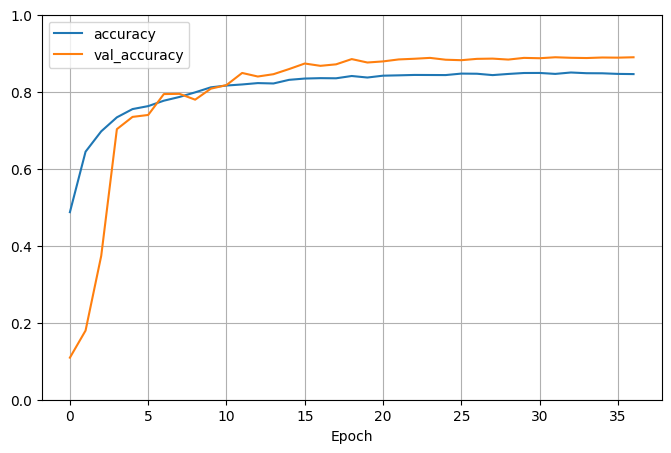

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4829 - loss: 1.4409 - val_accuracy: 0.1103 - val_loss: 2.1893 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6808 - loss: 0.9041 - val_accuracy: 0.1291 - val_loss: 2.2822 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7229 - loss: 0.7800 - val_accuracy: 0.5239 - val_loss: 1.1982 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7617 - loss: 0.6835 - val_accuracy: 0.7645 - val_loss: 0.6531 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7894 - loss: 0.6078 - val_accuracy: 0.7544 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 6/40
183/188 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8071 - loss: 0.5683
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8072 - loss: 0.5681 

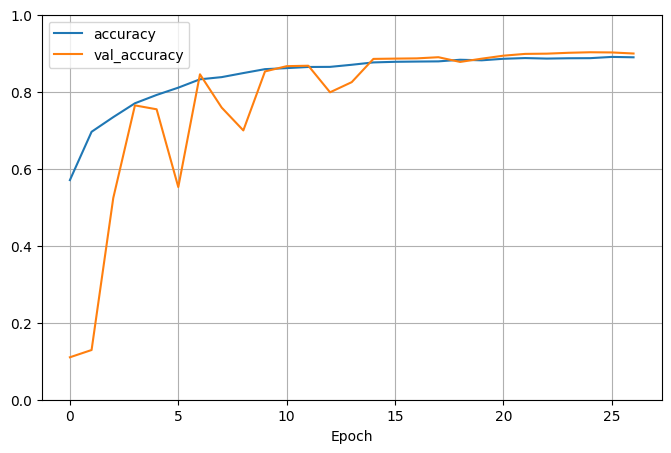

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4373 - loss: 1.5479 - val_accuracy: 0.1577 - val_loss: 2.1564 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6295 - loss: 1.0541 - val_accuracy: 0.3006 - val_loss: 1.7360 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6888 - loss: 0.9017 - val_accuracy: 0.4619 - val_loss: 1.5477 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7227 - loss: 0.7914 - val_accuracy: 0.4748 - val_loss: 3.3874 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7478 - loss: 0.7288 - val_accuracy: 0.7318 - val_loss: 0.7883 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7769 - loss: 0.6512 - val_accuracy: 0.7296 - val_loss: 0.7221 - learning_rate: 0.0010
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7842 - loss: 0.6300

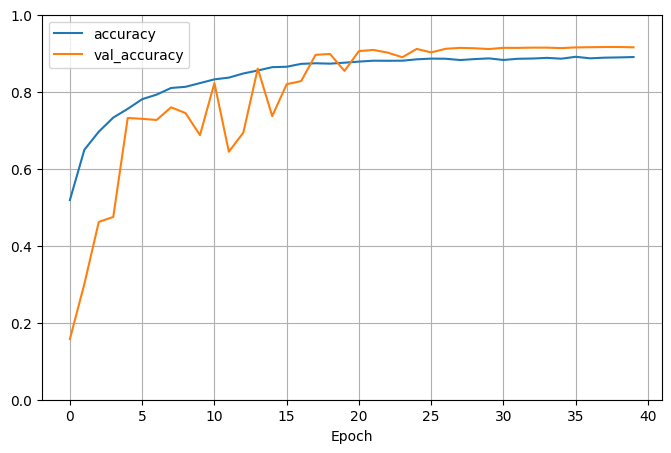

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),

    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

#### lastly tunning neuron number & activation function
for previous 3 model, we find that model is better at lr=0.001 and all drop rate is better at 0.3.

dropRate too high may lead to underfit problem, expectially for our small amount of data

In [ ]:
#hyper parameter
neuronNum=[32, 64, 100, 200]
activateFns=["relu", "tanh"]

def build_model(hp):
    model = keras.models.Sequential()

    # Add the input layer
    model.add(keras.layers.Input(shape=input_shape))

    # === L2 regular ===
    l2_reg = regularizers.l2(1e-4)

    # conv layer two
    model.add(
            layers.Conv2D(filters = 16,
                        kernel_size = 3,
                        activation = hp.Choice(f"activateFns_1", values=activateFns),
                        padding = 'same',
                        kernel_regularizer = l2_reg,
                        input_shape=input_shape
            )
        )
    model.add(layers.BatchNormalization())

    model.add(
            layers.Conv2D(filters = 64,
                        kernel_size = 5,
                        activation = hp.Choice(f"activateFns_2", values=activateFns),
                        padding = 'same',
                        kernel_regularizer = l2_reg,
                        input_shape=input_shape
            )
        )
    model.add(layers.BatchNormalization())

    #pool layer
    model.add(
        layers.MaxPooling2D(pool_size=(2, 2)) #图像本来就小，pool不用那么激进 pool_size=(3,3)
    )
    model.add(
        layers.Dropout(rate=0.3)
    )
    model.add(
        layers.GlobalAveragePooling2D()
    )

    #fcn==fully connected network
    model.add(
        layers.Dense(
                units=hp.Choice(f"units", values=neuronNum),
                activation=hp.Choice("activation_3", values=activateFns),
                kernel_regularizer=l2_reg
        )
    )
    model.add(
        keras.layers.Dropout(rate=0.3)
    )

    #output layer
    model.add(
        layers.Dense(num_classes, activation='softmax') #output layer
    )

    # === compile model ===
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=None, # search all possibility
    executions_per_trial=1,
    overwrite=True
    # overwrite=False,
    # directory="keras_tuning_results",
    # project_name="cnn_assgn2"
)
tuner.search_space_summary()

Search space summary
Default search space size: 4
activateFns_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
activateFns_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 100, 200], 'ordered': True}
activation_3 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}


In [ ]:
tuner.search(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid),batch_size=batch_size,callbacks=callbacks)

Trial 31 Complete [00h 00m 56s]
val_accuracy: 0.8939999938011169

Best val_accuracy So Far: 0.918624997138977
Total elapsed time: 00h 23m 53s


In [ ]:
tuner.results_summary(10) #display best 10 trials

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0000 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 200
activation_3: relu
Score: 0.918624997138977

Trial 0025 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 64
activation_3: relu
Score: 0.9166250228881836

Trial 0010 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 200
activation_3: tanh
Score: 0.8992499709129333

Trial 0030 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 32
activation_3: tanh
Score: 0.8939999938011169

Trial 0028 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 64
activation_3: tanh
Score: 0.893875002861023

Trial 0012 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: relu
units: 32
activation_3: relu
Score: 0.890874981880188

Trial 0009 summary
Hyperparameters:
activateFns_1: relu
activateFns_2: tanh
units: 100
acti

#### compare top-2 hyperparam model
200 neuron perform is similar to 64 neruon, we prefer 64 neuron for computational cost
all other activation function is relu

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.4790 - loss: 1.4254 - val_accuracy: 0.3121 - val_loss: 1.9428 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6835 - loss: 0.8985 - val_accuracy: 0.2216 - val_loss: 2.1387 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7464 - loss: 0.7378 - val_accuracy: 0.4964 - val_loss: 1.2638 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7815 - loss: 0.6482 - val_accuracy: 0.5270 - val_loss: 1.2882 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7996 - loss: 0.5957 - val_accuracy: 0.6630 - val_loss: 0.9226 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8165 - loss: 0.5378 - val_accuracy: 0.7362 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8317 - loss: 0.501

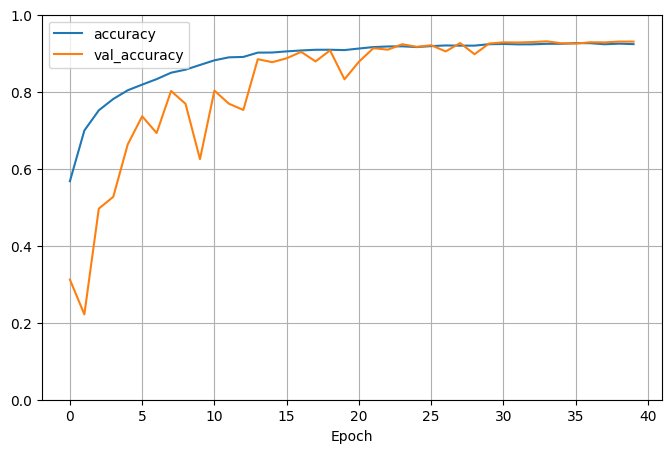

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

#### valid plot

Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.5414 - loss: 1.2852 - val_accuracy: 0.1094 - val_loss: 2.3388 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7322 - loss: 0.7690 - val_accuracy: 0.1982 - val_loss: 2.8514 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7783 - loss: 0.6380 - val_accuracy: 0.5314 - val_loss: 1.2421 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8086 - loss: 0.5567 - val_accuracy: 0.3828 - val_loss: 3.4847 - learning_rate: 0.0010
Epoch 5/40
187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8265 - loss: 0.5055
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8266 - loss: 0.5054 - val_accuracy: 0.6225 - val_loss: 1.6018 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8585 - loss: 0.4

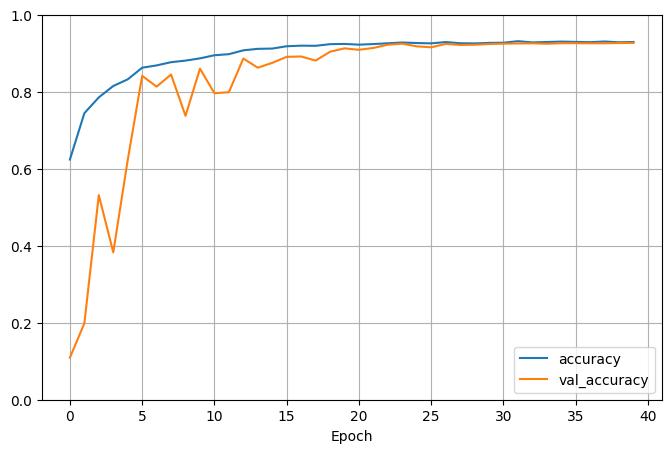

In [ ]:
# === build model ===
model = keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(200, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# pr_callback = PrecisionRecallCallback(X_train, y_train, X_valid, y_valid)
# === callback setting ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    # pr_callback
]

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

Test set performance 
              precision    recall  f1-score   support

           0      0.801     0.951     0.870       873
           1      0.982     0.902     0.940       858
           2      0.601     0.318     0.416       877
           3      0.797     0.907     0.849       914
           4      0.633     0.604     0.618       737
           5      0.624     0.552     0.586      1072
           6      0.475     0.126     0.199       682
           7      0.469     0.558     0.510       813
           8      0.474     0.755     0.582      1174

    accuracy                          0.647      8000
   macro avg      0.651     0.630     0.619      8000
weighted avg      0.649     0.647     0.628      8000



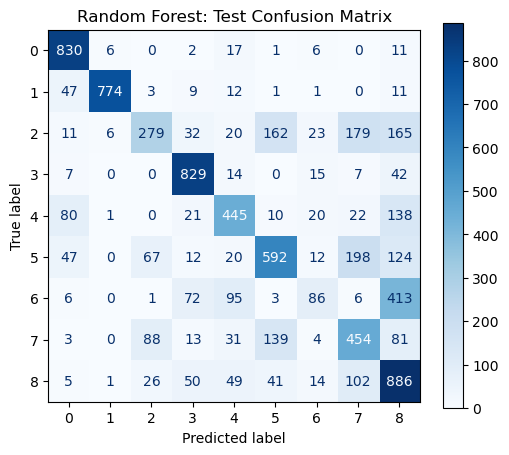

In [ ]:
X_train_final = np.concatenate([X_train_pca, X_valid_pca])
y_train_final = np.concatenate([y_train, y_valid])

best_rf.fit(X_train_final, y_train_final)
test_pred = best_rf.predict(X_test_pca)


print("Test set performance ")
print(classification_report(y_test, test_pred, digits=3))

fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, test_pred, cmap="Blues", values_format="d", ax=ax)
plt.title("Random Forest: Test Confusion Matrix")
plt.show()


### Fully connected neural network

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3591 - loss: 1.7262 - val_accuracy: 0.5291 - val_loss: 1.2546 - learning_rate: 0.1000
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5358 - loss: 1.2301 - val_accuracy: 0.5860 - val_loss: 1.1215 - learning_rate: 0.1000
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5633 - loss: 1.1355 - val_accuracy: 0.6010 - val_loss: 1.0833 - learning_rate: 0.1000
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5895 - loss: 1.0808 - val_accuracy: 0.6125 - val_loss: 1.0362 - learning_rate: 0.1000
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6109 - loss: 1.0263 - val_accuracy: 0.6275 - val_loss: 1.0173 - learning_rate: 0.1000
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6273 - loss: 0.9923 - val_accuracy: 0.6354 - val_loss: 0.9905 - learning_rate: 0.1000
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6403 - loss: 0.9542 - 

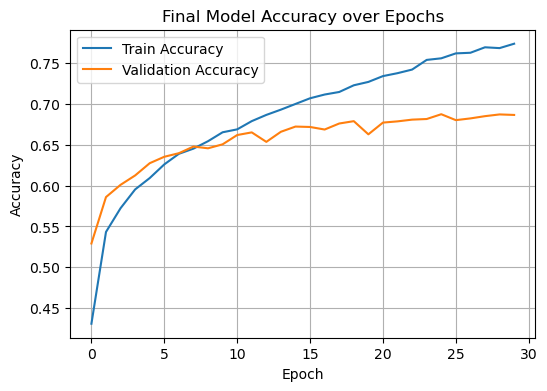

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       873
           1       0.97      0.90      0.94       858
           2       0.58      0.31      0.40       877
           3       0.90      0.90      0.90       914
           4       0.67      0.62      0.65       737
           5       0.65      0.70      0.68      1072
           6       0.50      0.38      0.43       682
           7       0.47      0.57      0.52       813
           8       0.56      0.72      0.63      1174

    accuracy                           0.69      8000
   macro avg       0.68      0.67      0.67      8000
weighted avg       0.69      0.69      0.68      8000



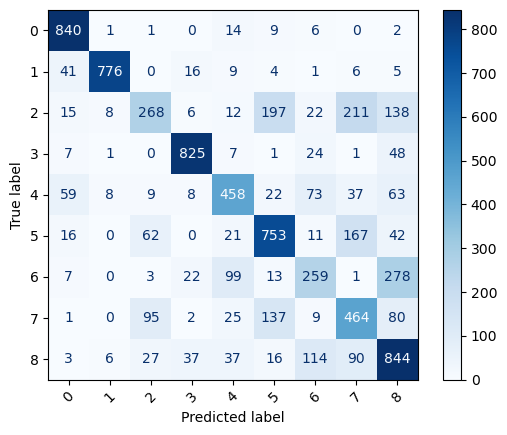

In [ ]:
# Best hyperparameters obtained using Section 3 tuning
final_params = {'units': 256, 'activation': 'relu', 'dropout': 0.2, 'lr': 0.1}

# Building the final model
final_model = keras.models.Sequential()
final_model.add(keras.layers.Input(shape=(X_train_pca.shape[1],)))

for i in range(1, 3):
    final_model.add(keras.layers.Dense(
        units=final_params['units'],
        activation=final_params['activation']
    ))
    final_model.add(keras.layers.Dropout(rate=final_params['dropout']))

final_model.add(keras.layers.Dense(len(np.unique(y_train)), activation='softmax'))

final_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=final_params['lr']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train final model
history = final_model.fit(
    X_train_pca, y_train,
    validation_data=(X_valid_pca, y_valid),
    epochs=30,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
    ]
)

# Evaluate on test set
test_loss, test_acc = final_model.evaluate(X_test_pca, y_test)
print(f"\nFinal Model Test Accuracy: {test_acc:.4f}")

# Plot accuracy curve
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Final Model Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Classification report & confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict test set
y_pred_probs = final_model.predict(X_test_pca)
y_pred = np.argmax(y_pred_probs, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### Convolutional neural network（GPU）
by previous tunning, we get filter_1=16 , ken_1=3 , filter_2=64 , ken_2=5, lr=0.001, all dropRate=0.3, neuronNum=64 and all activateFns='relu'

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Epoch 1/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.4987 - loss: 1.3954 - val_accuracy: 0.1795 - val_loss: 2.1318 - learning_rate: 0.0010
Epoch 2/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7007 - loss: 0.8555 - val_accuracy: 0.2037 - val_loss: 2.2839 - learning_rate: 0.0010
Epoch 3/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7580 - loss: 0.6993 - val_accuracy: 0.4010 - val_loss: 1.5294 - learning_rate: 0.0010
Epoch 4/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7930 - loss: 0.6001 - val_accuracy: 0.6480 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 5/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.8216 - loss: 0.5311 - val_accuracy: 0.6300 - val_loss: 0.9445 - learning_rate: 0.0010
Epoch 6/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8354 - loss: 0.4903 - val_accuracy: 0.6848 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 7/40
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.8556 - loss:

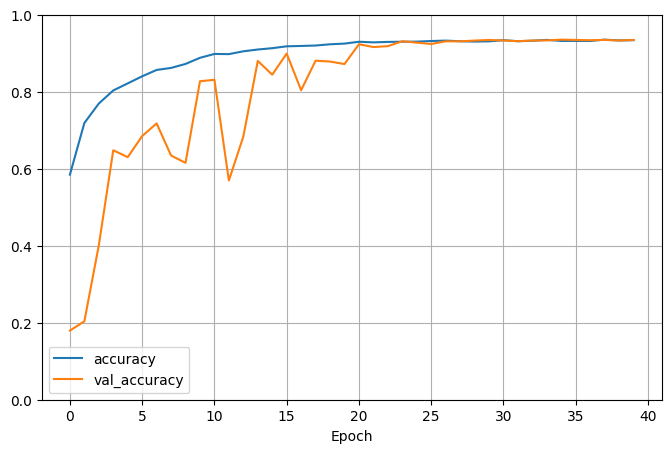

In [ ]:
# ===== global Variable start =====

# === parameter setting ===
batch_size = 128
epochs = 40
num_classes = len(np.unique(y_train))
input_shape = X_train.shape[1:]

# === L2 regular ===
l2_reg = regularizers.l2(1e-4)

pr_callback = PrecisionRecallCallback(X_train, y_train, X_valid, y_valid)
# === callback setting ===
callbacks = [
    # EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    pr_callback
]
# ===== global Variable end =====

# === build model ===
model = keras.Sequential([
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2_reg, input_shape=input_shape),
    layers.BatchNormalization(),

    layers.Conv2D(64, 5, padding='same', activation='relu', kernel_regularizer=l2_reg),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=l2_reg),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# === compile model ===
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === train model ===
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks
)

# === evaluate model ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

plot_history(history)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0     0.9842    0.9966    0.9903       873
           1     0.9907    0.9965    0.9936       858
           2     0.9129    0.8483    0.8794       877
           3     0.9604    0.9825    0.9713       914
           4     0.9325    0.9376    0.9350       737
           5     0.9303    0.9338    0.9320      1072
           6     0.8996    0.8798    0.8895       682
           7     0.8235    0.8549    0.8389       813
           8     0.9387    0.9395    0.9391      1174

    accuracy                         0.9321      8000
   macro avg     0.9303    0.9299    0.9299      8000
weighted avg     0.9322    0.9321    0.9319      8000



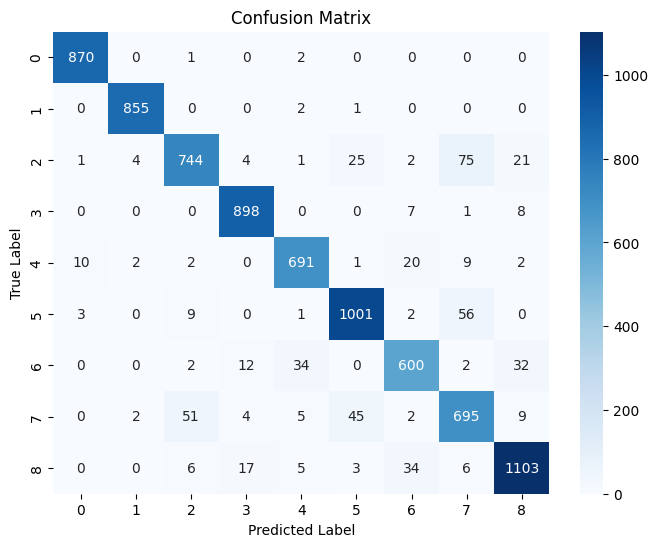

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # 将概率转换为类别索引
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

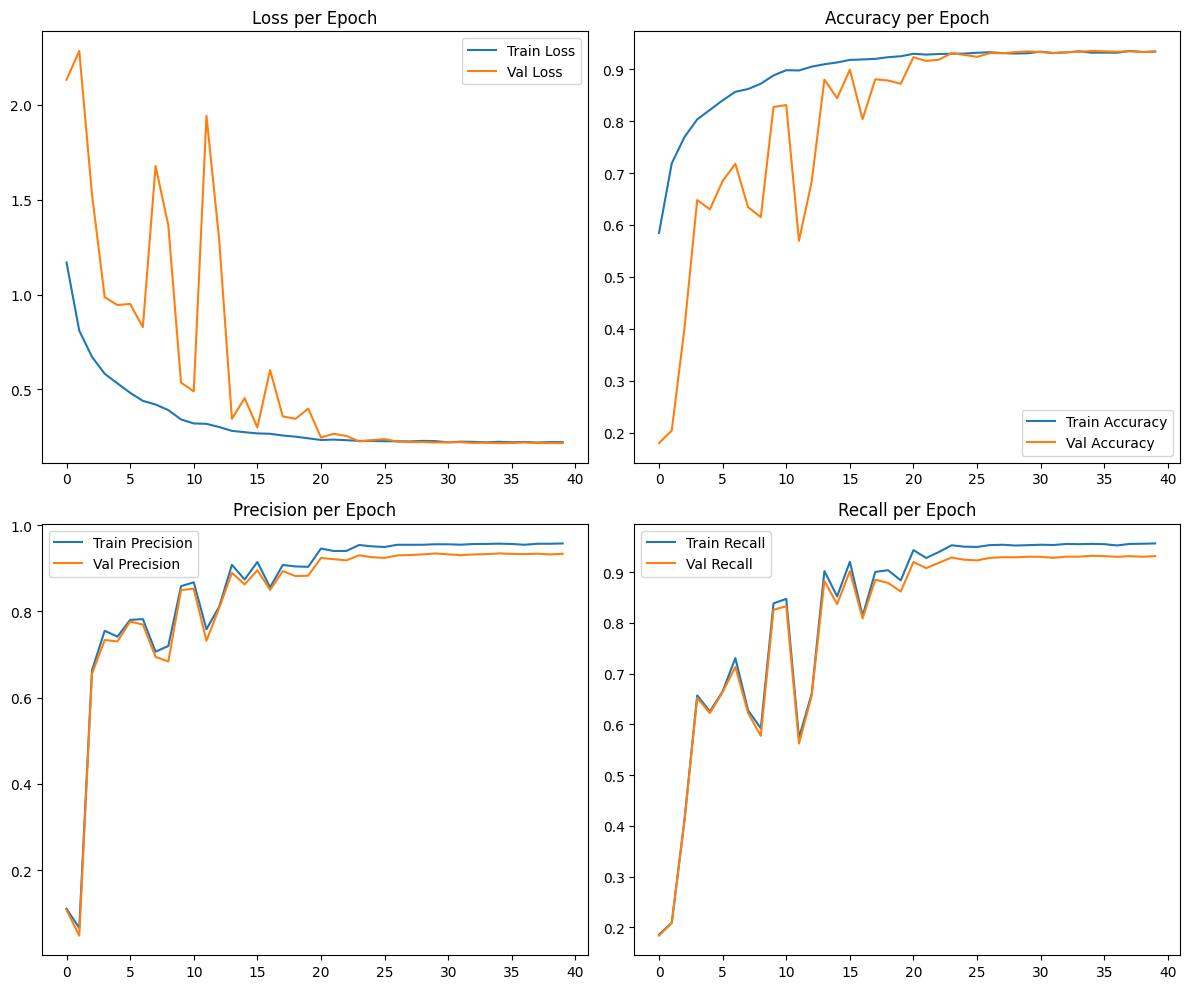

In [ ]:
# plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Loss
axs[0, 0].plot(history.history['loss'], label='Train Loss')
axs[0, 0].plot(history.history['val_loss'], label='Val Loss')
axs[0, 0].set_title('Loss per Epoch')
axs[0, 0].legend()

# Accuracy
axs[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axs[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axs[0, 1].set_title('Accuracy per Epoch')
axs[0, 1].legend()

# Precision
axs[1, 0].plot(pr_callback.train_precisions, label='Train Precision')
axs[1, 0].plot(pr_callback.precisions, label='Val Precision')
axs[1, 0].set_title('Precision per Epoch')
axs[1, 0].legend()

# Recall
axs[1, 1].plot(pr_callback.train_recalls, label='Train Recall')
axs[1, 1].plot(pr_callback.recalls, label='Val Recall')
axs[1, 1].set_title('Recall per Epoch')
axs[1, 1].legend()

plt.tight_layout()
plt.show()